In [1]:
import csv
import pandas as pd
import time
import sys
import itertools
from datetime import datetime
import sys
import networkx as nx
import plotly as py
import plotly.graph_objects as go
from plotly.graph_objs import *
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.stats.stats import pearsonr
import community
import matplotlib.cm as cm
%matplotlib inline

In [2]:
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans

In [6]:
def get_names_for_download(dates):
    pwd = '/home/b00762654/twitter_None'
    for i in range(len(dates) - 1):
        csv_name = pwd + '/data_'+ str(dates[i]) + '_' + str(dates[i+1]) + '.csv'
        print(csv_name)

## Functions

In [8]:
#Returns a dict of dataframe with twitter data from folder data/
def load_folder_as_dict(dates, prefix='data/', subset=False, n_subset=100):
    dict_df = dict()
    for i in range(len(dates) - 1):
        csv_name = prefix + 'data_'+ str(dates[i]) + '_' + str(dates[i+1]) + '.csv'
        df_name = 'df_' + str(dates[i])
        df = pd.read_csv(csv_name)
        df = df[df.is_retweeted == True]
        if subset:
            df = df[:n_subset]
        dict_df[df_name] = df
    return dict_df

In [9]:
#Output stats on dataframes --> to do with the whole dataset
def get_stats_on_df(dict_df):
    l_1 = []
    l_2 = []

    for key in dict_df.keys():
        df = dict_df[key]
        l_user_rt = list(df[df.is_retweeted == True].user_retweeted.unique())
        l_users = list(df[df.is_retweeted == True].username.unique())
        l_tot = l_users.copy()
        print('DATE: ', key)
        print('Nb unique user retweeted for ', key, ' : ', len(l_user_rt))
        print('Nb unique users who tweet for ', key, ' : ', len(l_users))
        l_tot.extend(l_user_rt)
        print('Nb unique users for ', key, ' : ', len(list(set(l_tot))))
        G = define_graph_from_df(df)
        G_und = G.to_undirected()
        print('Nodes in RT network:', len(G.nodes()))
        print('Edges in RT network:', len(G.edges()))
        num_of_cc = nx.number_connected_components(G_und)
        print("Number of connected components: {}".format(num_of_cc))
        # Get the greatest connected component subgraph
        gcc_nodes = max(nx.connected_components(G_und), key=len)
        gcc = G_und.subgraph(gcc_nodes)
        print("Number of nodes in GCC: {}".format(len(gcc_nodes)))
        node_fraction = gcc.number_of_nodes() / float(G_und.number_of_nodes())
        edge_fraction = gcc.number_of_edges() / float(G_und.number_of_edges())
        print("Fraction of nodes in GCC: {:.3f}".format(node_fraction))
        print("Fraction of edges in GCC: {:.3f}".format(edge_fraction))
        print()
        l_1.extend(l_user_rt)
        l_2.extend(l_users)
    print()
    print('Nb of unique users retweeted for al these df :', len(list(set(l_1))))
    print('Nb of unique users who tweet for al these df :', len(list(set(l_2))))
    return

In [10]:
#Returns a directed graph from the datafrmae
def define_graph_from_df(df):
    G = nx.from_pandas_edgelist(
        df,
        source = 'username', 
        target = 'user_retweeted',
        create_using = nx.DiGraph())
    return G

In [11]:
#Returns a dictionnary of directed graphs from a dictionnary of dataframe
def define_graphs(dict_df):
    graph_dict = dict()
    for key in dict_df.keys():
        graph_dict[key] = define_graph_from_df(dict_df[key])
    return graph_dict

In [12]:
#Returns the max connected component in graph and dataframe format
def get_df_G_connected_comp(G, df):
    G_und = G.to_undirected()
    gcc_nodes = max(nx.connected_components(G_und), key=len)
    df = df[(df.username.isin(list(gcc_nodes))) | (df.user_retweeted.isin(list(gcc_nodes)))]
    gcc = define_graph_from_df(df)
    return gcc, df

In [13]:
#Returns a list of dataframes with connected components from the inital one (UNUSED)
#Use it if you want to analyse different connected component inside 1 day
def split_by_connected_components(G, df, limit=5):
    G_und = G.to_undirected()
    subdf_sorted = list()
    gcc_nodes = max(nx.connected_components(G_und), key=len)
    while len(gcc_nodes) > limit:
        df_res = df[(df.username.isin(list(gcc_nodes))) | (df.user_retweeted.isin(list(gcc_nodes)))]
        subdf_sorted.append(df_res)
        print(subdf_sorted[-1].shape)
        G_und.remove_nodes_from(gcc_nodes)
        gcc_nodes = max(nx.connected_components(G_und), key=len)
    return subdf_sorted

## Nodes Information

In [14]:
#Return dictionnary of degree centrality for each node
def compute_degree_centrality(G):
    degree_centrality = {}
    for node in G.nodes():
        degree_centrality[node] = [G.degree(node),  G.in_degree(node), G.out_degree(node)]
    return degree_centrality

In [15]:
#Feature Engineering of nodes
#Louvain Clustering is included in that dataframe!
def define_df_nodes(df, G):
    
    df_nodes = df[df.is_retweeted == True]
    df_nodes.loc[:, 'count_rt_day'] = df_nodes.groupby('user_retweeted').user_retweeted.transform('count')
    df_nodes.loc[:, 'count_t_day'] = df_nodes.groupby('username').username.transform('count')

    df_nodes_1 = df_nodes[['user_retweeted', 'count_rt_day']].drop_duplicates()
    df_nodes_1.columns = ['username', 'count_rt_day']
    df_nodes_2 = df_nodes[['username', 'count_t_day']].drop_duplicates()
    
    df = pd.merge(df_nodes_1, df_nodes_2, on='username', how='outer')
    #compute closeness centrality for each nodes
    df_closeness = pd.DataFrame(nx.closeness_centrality(G).items(), columns=['username', 'closeness_centrality'])
    #compute harmonic centrality for each nodes --> same results as above
    #df_harmonic = pd.DataFrame(nx.harmonic_centrality(G).items(), columns=['username', 'harmonic_centrality'])
    #compute betweenness centrality for each nodes
    df_betweenness = pd.DataFrame(nx.betweenness_centrality(G).items(), columns=['username', 'betweenness_centrality'])
    #compute the degree centrality for each nodes
    df_degree = pd.DataFrame(compute_degree_centrality(G)).T.reset_index()
    df_degree.columns = ['username', 'degree', 'in_degree', 'out_degree']  
    #computer pagerank importance
    df_pagerank = pd.DataFrame(nx.pagerank(G, alpha=0.9).items(), columns=['username', 'pagerank_value'])
    
    #define cluster_id according to Louvain method
    G_und = G.to_undirected()
    partition = community.best_partition(G_und)
    df_clusters = pd.DataFrame(partition.items(), columns=['username', 'cluster_id'])
    
    
    df = pd.merge(df, df_closeness, on='username', how='outer')
    #df = pd.merge(df, df_harmonic, on='username', how='outer')
    df = pd.merge(df, df_degree, on='username', how='outer')
    df = pd.merge(df, df_betweenness, on='username', how='outer')
    df = pd.merge(df, df_pagerank, on='username', how='outer')
    df = pd.merge(df, df_clusters, on='username', how='outer')
    
    df.loc[:, 'modularity'] = community.modularity(partition, G_und)
    
    df.fillna(0, inplace=True)
    
    return df

## Edges Information

In [16]:
#Feature Engineering of Edges
def define_df_edges(df, G):
    df_edges = df[['username', 'user_retweeted', 'timestamp', 'count_rt', 'text']].copy()
    df_edges.loc[:, 'count_rt_day'] = df_edges.groupby('user_retweeted').user_retweeted.transform('count')
    df_edges.loc[:, 'count_t_day'] = df_edges.groupby('username').username.transform('count')
    
    df_edges.loc[:, 'count_t_day'] = df_edges.groupby('username').username.transform('count')
    
    return df_edges

In [17]:
#df_edges.sort_values('count_t_day', ascending=False).head(10)

## Clustering And Visualization

Two type of partition format:
- list format : [{nodeset_cluster1}, {nodeset_cluster2}, ...]
- dict format: {node1:cluser_id1, node2:cluster_id2 ...}

In [18]:
#Less efficient than louvain clustering
def spectral_clustering(G, k=2):
    nodelist = list(G)
    adj_mat = nx.to_numpy_matrix(G)
    sc = SpectralClustering(k, affinity='precomputed', n_init=100, )
    sc.fit(adj_mat)

    labels = sc.labels_
    
    partition = [set() for _ in range(k)]
    for i in range(len(nodelist)):
        partition[labels[i]].add(nodelist[i])
        
    return partition

In [19]:
def louvain_clustering(G):
    G_und = G.to_undirected()
    partition = community.best_partition(G_und)
    keys = list(set(partition.values()))
    data = {key: [] for key in keys}
    for node, commId in partition.items():
        data[commId].append(node)
    part_fin = []
    for nodeset in data.values():
        part_fin.append(set(nodeset))
    return part_fin

In [78]:
def visualize_clusters(G, partition, save_name):
    colors=[]
    plt.figure(figsize=(20,15))
    for i in range(len(partition)):
        colors.append(cm.Set1(i))
    pos=nx.spring_layout(G) # positions for all nodes
    
    for commId, nodeset in enumerate(partition):
        nx.draw_networkx_nodes(G, pos, nodelist=nodeset, node_color=colors[commId],
                               node_size=100, alpha=0.4)
    
    nx.draw_networkx_edges(G, pos, alpha=0.1)
    plt.savefig(save_name)
    plt.close()
    #plt.show()

def visualize_clusters_labels(G, partition, dict_lab, save_name):
    colors=[]
    plt.figure(figsize=(15,10))
    for i in range(len(partition)):
        colors.append(cm.Set1(i))
    pos=nx.spring_layout(G) # positions for all nodes
    
    for commId, nodeset in enumerate(partition):
        nx.draw_networkx_nodes(G, pos, nodelist=nodeset, node_color=colors[commId],
                               node_size=100, alpha=0.3)
    
    nx.draw_networkx_labels(G, pos, labels=dict_lab, font_size=15, font_weight='bold')
    nx.draw_networkx_edges(G, pos, alpha=0.1)
    plt.savefig(save_name)
    plt.close()
    #plt.show()

In [143]:
def compute_modularity(G, partition):
    G_und = G.to_undirected()
    dict_partition = dict()
    for i in range(len(partition)):
        for node in partition[i]:
            dict_partition[node] = i
    modularity = community.modularity(dict_partition, G_und)
    return modularity

In [144]:
def filter_communities_with_limit(partition, limit_agg=10):
    new_part = []
    nodes_without_com = []
    for i in range(len(part)):
        if len(part[i]) > limit_agg:
            new_part.append(part[i])
        else:
            nodes_without_com += list(part[i])
    new_part.append(set(nodes_without_com))
    return new_part

In [145]:
#Two type of clustering format (see above), returns list format from dict format
def change_format_clustering(partition_dict):
    keys = list(set(partition_dict.values()))
    data = {key: [] for key in keys}
    for node, commId in partition_dict.items():
        data[commId].append(node)
    part_fin = []
    for nodeset in data.values():
        part_fin.append(set(nodeset))
    return part_fin

In [146]:
def vizualize_from_df(df_nodes, G, savename='test'):
    #G_und = G.to_undirected(G)
    partition_dict = dict(zip(df_nodes.username, df_nodes.cluster_id))
    partition_list = change_format_clustering(partition_dict)

    return visualize_clusters(G, partition_list, savename)

In [147]:
def vizualize_from_df_closeness(df_nodes, G, top=10, savename='test'):
    #G_und = G.to_undirected(G)
    partition_dict = dict(zip(df_nodes.username, df_nodes.cluster_id))
    partition_list = change_format_clustering(partition_dict)
    
    #node information
    nodes_labeled = df_nodes.sort_values('closeness_centrality', ascending=False).username[:top]
    dict_nodes_labeled = dict(zip(nodes_labeled, nodes_labeled))
    
    return visualize_clusters_labels(G, partition_list, dict_nodes_labeled, savename)

In [148]:
def vizualize_from_df_pagerank(df_nodes, G, top=10, savename='test'):
    #G_und = G.to_undirected(G)
    partition_dict = dict(zip(df_nodes.username, df_nodes.cluster_id))
    partition_list = change_format_clustering(partition_dict)
    
    #node information
    nodes_labeled = df_nodes.sort_values('pagerank_value', ascending=False).username[:top]
    dict_nodes_labeled = dict(zip(nodes_labeled, nodes_labeled))
    
    return visualize_clusters_labels(G, partition_list, dict_nodes_labeled, savename)

In [149]:
def vizualize_from_df_betweenness(df_nodes, G, top=10, savename='test'):
    #G_und = G.to_undirected(G)
    partition_dict = dict(zip(df_nodes.username, df_nodes.cluster_id))
    partition_list = change_format_clustering(partition_dict)
    
    #node information
    nodes_labeled = df_nodes.sort_values('betweenness_centrality', ascending=False).username[:top]
    dict_nodes_labeled = dict(zip(nodes_labeled, nodes_labeled))
    
    return visualize_clusters_labels(G, partition_list, dict_nodes_labeled, savename)

In [1]:
def reassign_top_clusters(df_nodes, top_clusters):
    s_top_clusters = df_nodes.groupby('cluster_id').cluster_id.count().sort_values(ascending=False)[:top_clusters]
    l_top_clusters = list(s_top_clusters.index)
    
    def reassign_clusters(cluster_id):
        if cluster_id not in l_top_clusters:
            return other_cluster_id
        else:
            return cluster_id
    
    other_cluster_id = random.choice([x for x in range(999) if x not in l_top_clusers])
    df_nodes.loc[:, 'new_cluster_id'] = df_nodes.cluster_id.apply(reassign_clusters)
    return df_nodes

## PIPELINE

In [154]:
dates = ['2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31',
        '2020-04-01', '2020-04-02', '2020-04-03', '2020-04-04',
        '2020-04-05', '2020-04-06', '2020-04-07', '2020-04-08',
         '2020-04-09', '2020-04-10']
dates= ['2020-04-08', '2020-04-09']
top_users_display = 10
filter_by_top_cluster = True
top_clusters_display=10
param_subset=False
param_n_subset=1000

Range of dates: ['2020-04-08', '2020-04-09']
Date:  2020-04-08


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

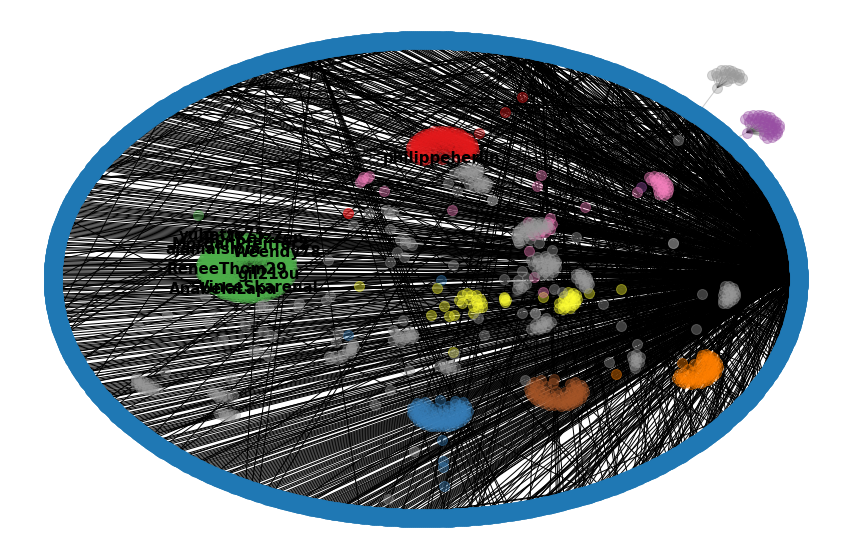

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

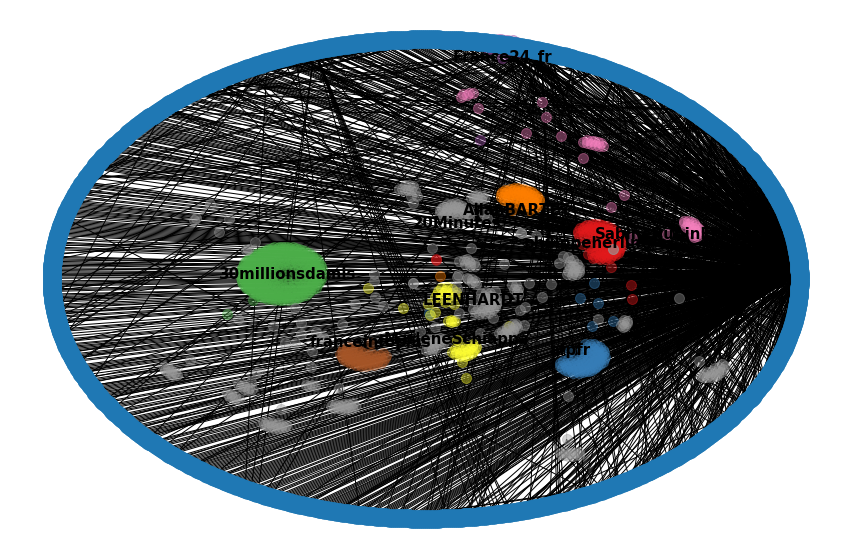

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

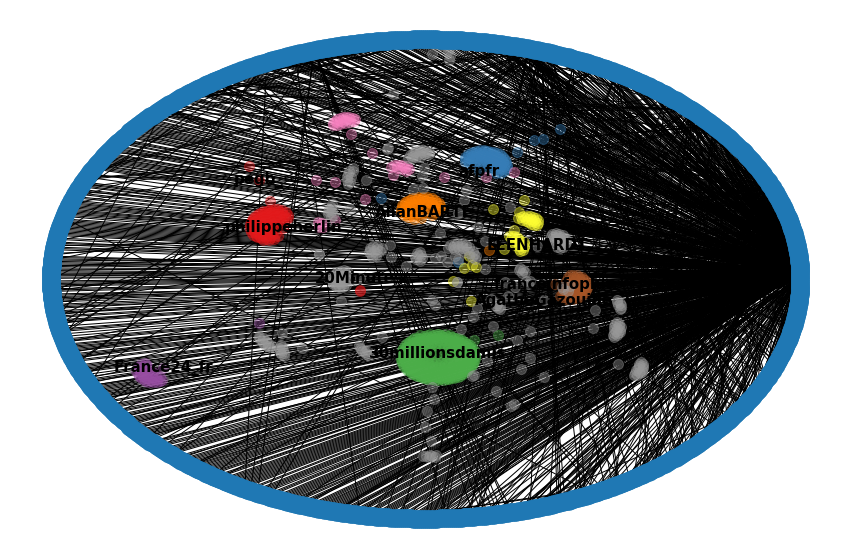

Time taken (sec): 53.254453897476196


In [155]:
if __name__=='__main__':
    df_dict = load_folder_as_dict(dates, prefix='data/', subset=param_subset, n_subset=param_n_subset)
    graph_dict = define_graphs(df_dict)
    print('Range of dates:', dates)

    for key in list(df_dict.keys()):
        t1 = time.time()
        print('Date: ', str(key).split('_')[-1])

        df = df_dict[key]
        G = graph_dict[key]

        #Keep connected component
        G, df = get_df_G_connected_comp(G, df)
        G_und = G.to_undirected()

        #define df_nodes
        df_nodes = define_df_nodes(df, G)
        #Reassign top cluster for a better display
        if filter_by_top_cluster:
            df_nodes = reassign_top_clusters(df_nodes, top_clusters=top_clusters_display)
            df_nodes.loc[:, 'cluster_id'] = df_nodes.loc[:, 'new_cluster_id']
        print(df_nodes.cluster_id.nunique())
        print(df_nodes.new_cluster_id.nunique())
        savename_nodes  = 'processed_data/nodes/' + str(key).split('_')[-1]+'_nodes.csv'
        df_nodes.to_csv(savename_nodes,  encoding='utf-8')
        
        #define df_edges
        df_edges = define_df_edges(df, G)
        savename_edges  = 'processed_data/edges/' + str(key).split('_')[-1]+'_edges.csv'
        df_edges.to_csv(savename_edges,  encoding='utf-8')

        #compute and save figures according to clustering and (top) most important nodes
        savename_clusters  = 'visualisation/clusters/' + str(key).split('_')[-1]+'_clusters'
        vizualize_from_df(df_nodes, G_und, savename=savename_clusters)
        savename_clusters  = 'visualisation/betweenness/' + str(key).split('_')[-1]+'_betweenness'
        vizualize_from_df_betweenness(df_nodes, G_und, top=top_users_display ,savename=savename_clusters)
        savename_clusters  = 'visualisation/closeness/' + str(key).split('_')[-1]+'_closeness'
        vizualize_from_df_closeness(df_nodes, G_und, top=top_users_display ,savename=savename_clusters)
        savename_clusters  = 'visualisation/pagerank/' + str(key).split('_')[-1]+'_pagerank'
        vizualize_from_df_pagerank(df_nodes, G_und, top=top_users_display, savename=savename_clusters)
        
        t2 = time.time()
        delta_t = t2-t1
        print('Time taken (sec):', delta_t)
